# Predict RL via HM

Lukas Graz  
July 10, 2025

## Setup + Preprocessing

In [ ]:
suppressPackageStartupMessages({
  library(dplyr)
  library(ggplot2)
  library(kernlab)
  library(mgcv)  # for GAM models - smoothing
  library(gridExtra)  # for combining plots
})


In [ ]:
source("R/data_prep.R")


Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

In [ ]:
nams <- names(D)
nams[grep("HM|RL", nams)]


 [1] "HM_NOISELVL" "HM_NDVI"     "HM_NOISE"    "RL_NDVI"     "RL_NOISE"   
 [6] "HM_COORDX"   "HM_COORDY"   "RL_COORDX"   "RL_COORDY"   "RL_GCOORD"  
[11] "RL_GCOORDN"  "RL_GCOORDW" 

    HM_NDVI         HM_NOISE       RL_NDVI         RL_NOISE      ALONE        
 Min.   :0.110   Min.   :30.0   Min.   :0.000   Min.   :30.0   Mode :logical  
 1st Qu.:0.465   1st Qu.:41.0   1st Qu.:0.545   1st Qu.:30.9   FALSE:1024     
 Median :0.533   Median :46.4   Median :0.691   Median :41.4   TRUE :470      
 Mean   :0.529   Mean   :48.2   Mean   :0.644   Mean   :41.3                  
 3rd Qu.:0.601   3rd Qu.:54.4   3rd Qu.:0.797   3rd Qu.:48.6                  
 Max.   :0.843   Max.   :74.4   Max.   :0.883   Max.   :66.5                  
                                                                              
  WITH_DOG        WITH_KID        WITH_PAR        WITH_PNT      
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:1162      FALSE:1107      FALSE:707       FALSE:1219     
 TRUE :227       TRUE :249       TRUE :717       TRUE :96       
 NA's :105       NA's :138       NA's :70        NA's :179      
                                           

In [ ]:
cor(cbind(D_trn[c("DISTKM_sqrt", "JNYTIME_sqrt", "SPEED_log")]))


             DISTKM_sqrt JNYTIME_sqrt SPEED_log
DISTKM_sqrt        1.000       0.4894    0.7145
JNYTIME_sqrt       0.489       1.0000   -0.0835
SPEED_log          0.715      -0.0835    1.0000

Remove DIST_sqrt, as it is highly correlated with the other two.

## RL_NDVI

In [ ]:
lm_ndvi <- lm(RL_NDVI ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_ndvi <- step(lm_ndvi, trace = FALSE, k = log(nrow(D_trn)))
summary(fit <- lm(formula(step_ndvi), D_tst))



Call:
lm(formula = formula(step_ndvi), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.371 -0.430  0.182  0.698  1.989 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.1690     0.0946   -1.79  0.07452 .  
HM_NDVI             0.1581     0.0413    3.83  0.00015 ***
LANGGerman          0.2232     0.1064    2.10  0.03633 *  
LANGItalian         0.0028     0.1965    0.01  0.98866    
SPEED_log          -0.0720     0.0414   -1.74  0.08277 .  
JNYTIME_sqrt        0.1272     0.0415    3.07  0.00226 ** 
HM_NDVI:SPEED_log  -0.1848     0.0422   -4.38  1.4e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.958 on 536 degrees of freedom
Multiple R-squared:  0.0917,    Adjusted R-squared:  0.0815 
F-statistic: 9.02 on 6 and 536 DF,  p-value: 2.09e-09

-   R² = 0.08
-   Higher HM_NDVI corresponds to slightly higher RL-NDVI
-   higher JNYTIME_sqrt corresponds to slightly higher RL-NDVI
-   The faster (or further) you travel to RL, the more the RL_NDVI differs from HM_NDVI (negative interaction effect)

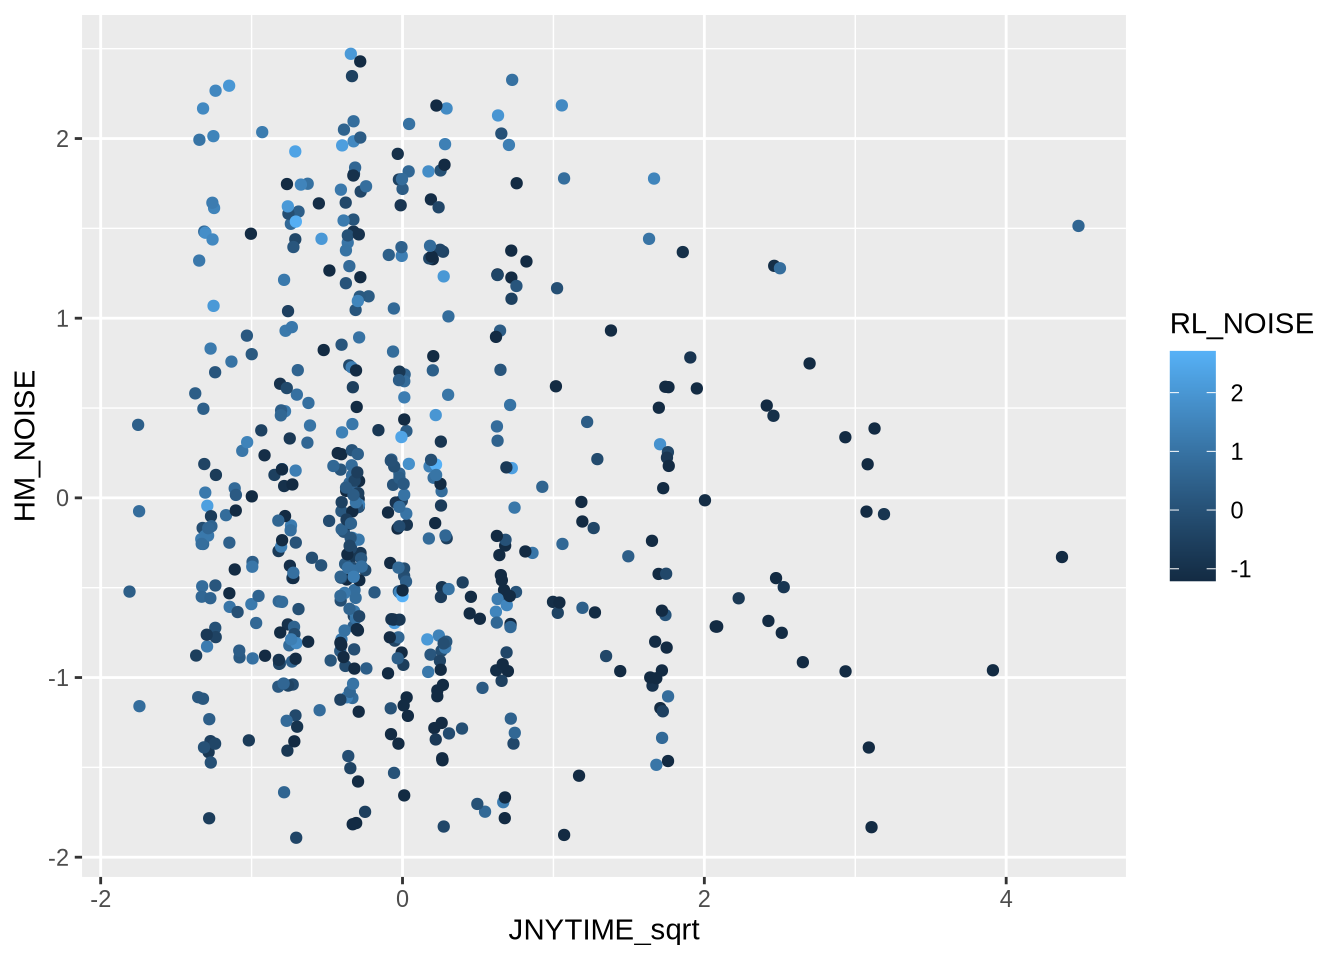

In [ ]:
ggplot(D_tst, aes(x = JNYTIME_sqrt, y=HM_NOISE, col = RL_NOISE)) +
  geom_jitter(width=0.07, height = 0.1)


## RL_NOISE

In [ ]:
lm_noise <- lm(RL_NOISE ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_noise <- step(lm_noise, trace = FALSE, k = log(nrow(D_trn)))
summary(lm(formula(step_noise), D_tst))



Call:
lm(formula = formula(step_noise), data = D_tst)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5097 -0.7495 -0.0467  0.6473  2.8683 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.03379    0.08896   -0.38  0.70426    
HM_NOISE               0.23846    0.03916    6.09  2.2e-09 ***
LANGGerman            -0.00494    0.09968   -0.05  0.96047    
LANGItalian            0.62198    0.18667    3.33  0.00092 ***
SPEED_log             -0.06326    0.03902   -1.62  0.10552    
JNYTIME_sqrt          -0.31956    0.03936   -8.12  3.2e-15 ***
HM_NOISE:JNYTIME_sqrt -0.03423    0.04070   -0.84  0.40061    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.904 on 536 degrees of freedom
Multiple R-squared:  0.193, Adjusted R-squared:  0.184 
F-statistic: 21.3 on 6 and 536 DF,  p-value: <2e-16

-   R² = 0.184
-   Participants can’t completely escape HM_NOISE (HM_NOISE positive predictor)
-   LANGItalians have it louder (than LANG de/fr)
-   Longer JNYTIME_sqrt leads to lower NOISE

Using automatic sigma estimation (sigest) for RBF or laplace kernel 

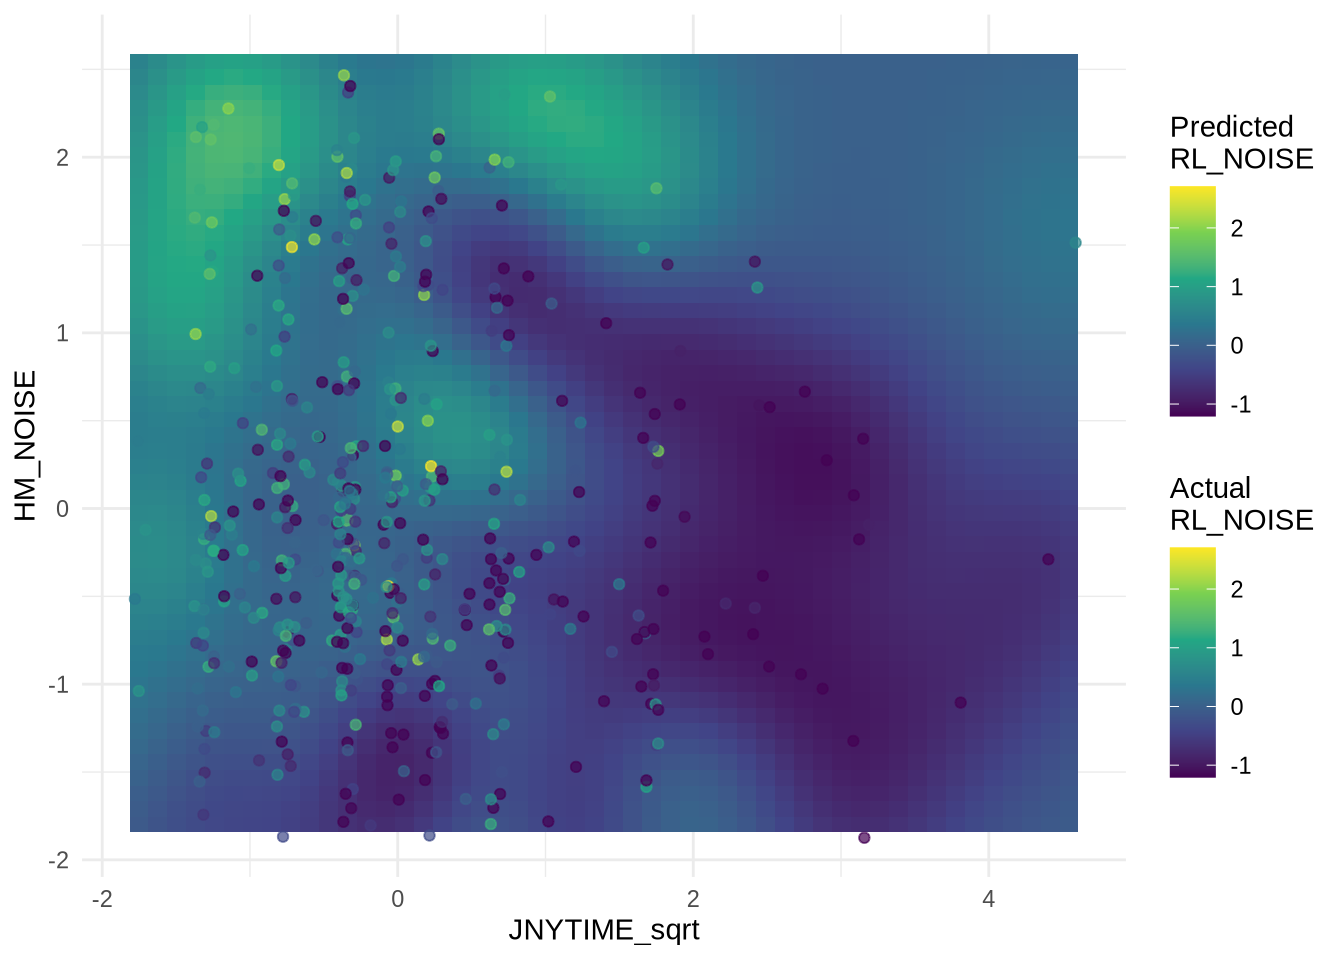

In [ ]:

# Fit Gaussian Process
X <- as.matrix(D_tst[, c("JNYTIME_sqrt", "HM_NOISE")])
y <- D_tst$RL_NOISE

# Fit GP with RBF kernel
gp_model <- gausspr(X, y, kernel = "rbfdot", kpar = "automatic")


In [ ]:
D$PRS <- rowMeans(cbind(D$FA,D$BA,D$EC,D$ES))

summary_fun <- function(x) c(mean = mean(x, na.rm = TRUE), 
                              sd = sd(x, na.rm = TRUE), 
                              median = median(x, na.rm = TRUE))

aggregate(PRS~ HM_NOISELVL, D, summary_fun)


  HM_NOISELVL PRS.mean PRS.sd PRS.median
1           1    4.989  0.886      5.000
2           2    4.928  0.915      4.917
3           3    4.857  0.926      4.833

  HM_NOISELVL FA.mean FA.sd FA.median
1           1    5.25  1.10      5.33
2           2    5.16  1.21      5.21
3           3    5.18  1.13      5.33

  HM_NOISELVL BA.mean BA.sd BA.median
1           1    5.11  1.20      5.00
2           2    5.04  1.17      5.00
3           3    4.95  1.20      5.00

  HM_NOISELVL EC.mean EC.sd EC.median
1           1    4.53  1.31      4.33
2           2    4.48  1.34      4.33
3           3    4.47  1.29      4.33

  HM_NOISELVL ES.mean ES.sd ES.median
1           1    5.07  1.42      5.19
2           2    5.04  1.38      5.00
3           3    4.83  1.55      5.00

## Plots for soundscape description

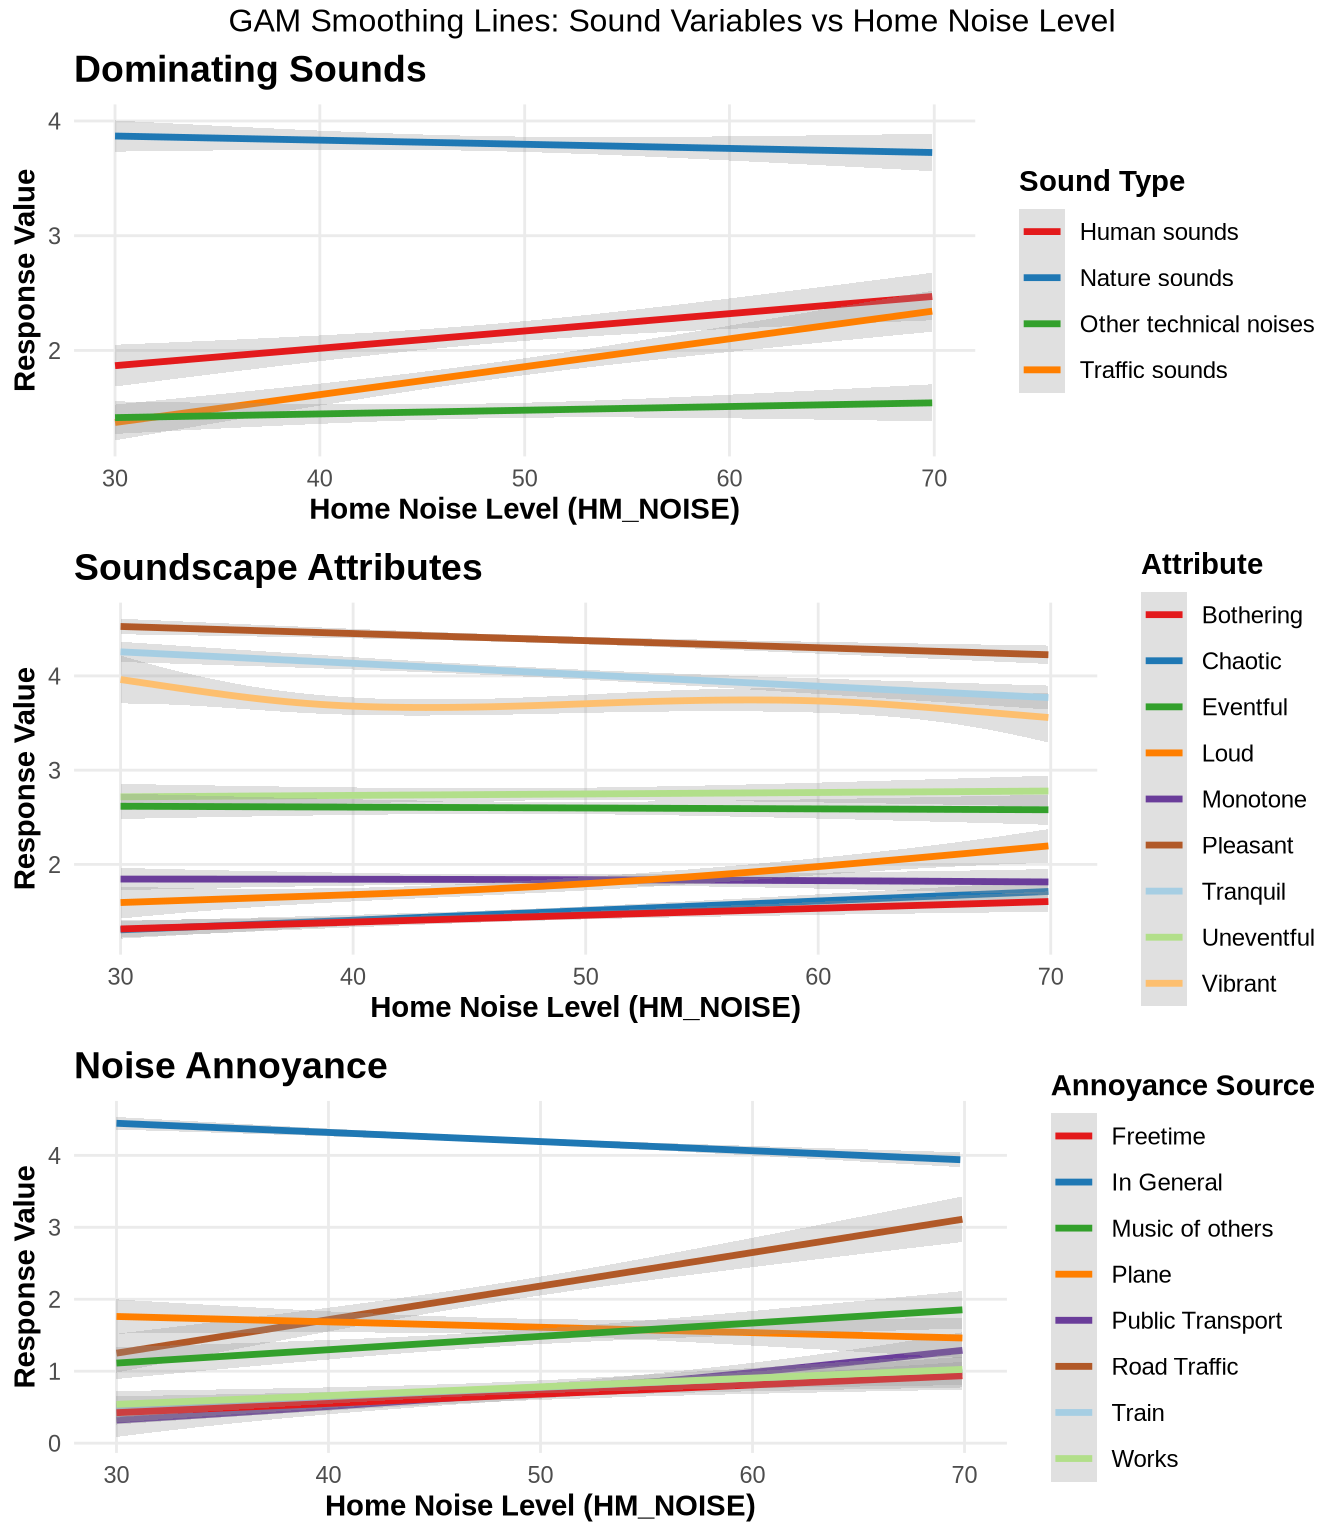

In [ ]:

# Define colors
colors <- c("#E31A1C", "#1F78B4", "#33A02C", "#FF7F00", "#6A3D9A", 
           "#B15928", "#A6CEE3", "#B2DF8A", "#FDBF6F")

# Create Plot 1: Dominating Sounds
suppressWarnings({
p1 <- ggplot(D, aes(x = HM_NOISE)) +
  geom_smooth(aes(y = LDOMAUD1, color = "Nature sounds"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LDOMAUD2, color = "Human sounds"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LDOMAUD3, color = "Traffic sounds"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LDOMAUD4, color = "Other technical noises"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  scale_color_manual(values = colors[1:4]) +
  labs(
    x = "Home Noise Level (HM_NOISE)",
    y = "Response Value",
    color = "Sound Type",
    title = "Dominating Sounds"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.title = element_text(size = 11, face = "bold"),
    legend.text = element_text(size = 9),
    axis.title = element_text(size = 11, face = "bold"),
    panel.grid.minor = element_blank()
  )
})

# Create Plot 2: Soundscape Attributes
p2 <- ggplot(D, aes(x = HM_NOISE)) +
  geom_smooth(aes(y = LSOUNDS1, color = "Pleasant"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS2, color = "Chaotic"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS3, color = "Vibrant"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS4, color = "Uneventful"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS5, color = "Tranquil"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS6, color = "Bothering"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS7, color = "Eventful"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS8, color = "Monotone"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSOUNDS9, color = "Loud"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  scale_color_manual(values = colors[1:9]) +
  labs(
    x = "Home Noise Level (HM_NOISE)",
    y = "Response Value",
    color = "Attribute",
    title = "Soundscape Attributes"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.title = element_text(size = 11, face = "bold"),
    legend.text = element_text(size = 9),
    axis.title = element_text(size = 11, face = "bold"),
    panel.grid.minor = element_blank()
  )

# For the noise annoyance variables, we need to handle the character values
# Convert character annoyance values to numeric
convert_annoyance <- function(x) {
  case_when(
    x == "00" ~ 0,
    x == "01" ~ 1,
    x == "02" ~ 2,
    x == "03" ~ 3,
    x == "04" ~ 4,
    x == "05" ~ 5,
    x == "06" ~ 6,
    x == "07" ~ 7,
    x == "08" ~ 8,
    x == "09" ~ 9,
    x == "10" ~ 10,
    x == "No annoyance" ~ 0,
    x == "Response scale mid-point" ~ 5,
    x == "Very annoying" ~ 10,
    TRUE ~ as.numeric(x)
  )
}


# Create a temporary data frame with converted values for noise annoyance
D_temp <- D |>
  mutate(
    LSANNOY1_num = convert_annoyance(LSANNOY1),
    LSANNOY2_num = convert_annoyance(LSANNOY2),
    LSANNOY3_num = convert_annoyance(LSANNOY3),
    LSANNOY4_num = convert_annoyance(LSANNOY4),
    LSANNOY5_num = convert_annoyance(LSANNOY5),
    LSANNOY6_num = convert_annoyance(LSANNOY6),
    LSANNOY7_num = convert_annoyance(LSANNOY7)
  )

# Create Plot 3: Noise Annoyance
p3 <- ggplot(D_temp, aes(x = HM_NOISE)) +
  geom_smooth(aes(y = LNOISE, color = "In General"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY1_num, color = "Road Traffic"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY2_num, color = "Public Transport"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY3_num, color = "Train"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY4_num, color = "Plane"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY5_num, color = "Freetime"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY6_num, color = "Music of others"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  geom_smooth(aes(y = LSANNOY7_num, color = "Works"), method = "gam", formula = y ~ s(x), se = TRUE, alpha = 0.3, size = 1.2) +
  scale_color_manual(values = colors[1:8]) +
  labs(
    x = "Home Noise Level (HM_NOISE)",
    y = "Response Value",
    color = "Annoyance Source",
    title = "Noise Annoyance"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.title = element_text(size = 11, face = "bold"),
    legend.text = element_text(size = 9),
    axis.title = element_text(size = 11, face = "bold"),
    panel.grid.minor = element_blank()
  )

xl <- xlim(30, 70)

# Combine all plots vertically
suppressWarnings({
  combined_plot <- grid.arrange(p1+xl, p2+xl, p3+xl, ncol = 1, 
                             top = "GAM Smoothing Lines: Sound Variables vs Home Noise Level")

})


-   [ ] one could add rugs to the plots above